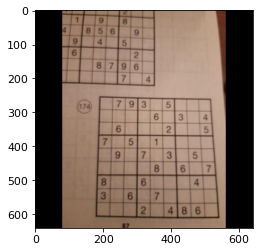

In [265]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, KFold
from PIL import Image
from ImageAnalysis import ImageAnalysis
from ImageTableExtraction import ImageTableExtraction
from SudokuDetection import SudokuDetection
from solvers.sudoku.sudoku_solver import SudokuSolver
filename = "C:/Temp/what8.jpg"
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [266]:
def perspective_transform(image, conjugates, output_size=640):
    output = np.float32([[0, 0], [output_size - 1, 0], [output_size - 1, output_size - 1], [0, output_size - 1]])
    matrix = cv2.getPerspectiveTransform(conjugates, output)
    return cv2.warpPerspective(image, matrix, (output_size, output_size), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

In [267]:
def to_rgb_from_bgr(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [268]:
from imgaug.augmenters.meta import Sequential
import imgaug.augmenters as iaa
import imageio
import torch

class SudokuExtractor():
    def __init__(self):
        self.count = 0
        self.model = torch.hub.load('C:/Projects/sudolver-models/data/model/yolov5', 'custom', path='C:/Projects/sudolver-models/data/trained_model/best_2022-04-09.pt', source='local') 

    def preprocess(self, image):
        aug = [iaa.CenterPadToSquare(), iaa.Resize({"height": 640, "width": 640})]
        seq = iaa.Sequential(aug)
        return seq(image=image)
        
    def predict(self, image):
        result = self.model(image)
        if len(result) > 0:
            pred = result.pandas()
            xmin, ymin, xmax, ymax = (int(pred.xyxy[0]['xmin'].values[0]), int(pred.xyxy[0]['ymin'].values[0]), int(pred.xyxy[0]['xmax'].values[0]), int(pred.xyxy[0]['ymax'].values[0]))
            return perspective_transform(image, self.pred_to_conjugates(xmin, ymin, xmax, ymax))
        else:
            return None
        
    def pred_to_conjugates(self, xmin, ymin, xmax, ymax):
        return np.float32([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])

requirements: pandas>=1.1.4 not found and is required by YOLOv5, attempting auto-update...
requirements: Command 'pip install 'pandas>=1.1.4'' returned non-zero exit status 1.
YOLOv5  v6.1-118-g3bb233a torch 1.10.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


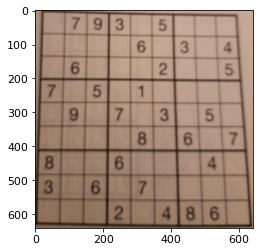

In [269]:
ex = SudokuExtractor()
img2 = ex.preprocess(img)
img2 = ex.predict(img2)
plt.imshow(img2)

53555
53555


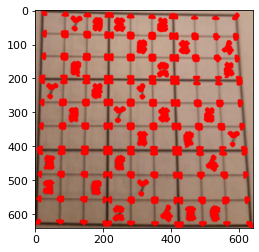

In [270]:
import math
from sklearn.neighbors import KNeighborsClassifier

def dist(pt1, pt2):
    (x1, y1), (x2, y2) = pt1, pt2
    #dist = math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    dist = (x2 - x1)**2 + (y2 - y1)**2
    return dist

gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img3 = img2.copy()
bi = cv2.bilateralFilter(gray, 5, 75, 75)
dst = cv2.cornerHarris(bi, 10, 17, 0.04)
mask = np.zeros_like(gray)        
mask[dst>0.01*dst.max()] = 255
#img3[dst > 0.01 * dst.max()] = [255, 0, 0]
coor = np.argwhere(mask)
coor_list = [l.tolist() for l in list(coor)]
coor_tuples = [tuple(reversed(l)) for l in coor_list]
left_top = None
right_top = None
left_bottom = None
right_bottom = None
    
i = 1    
points = coor_tuples.copy();
print(len(coor_tuples))
#for pt1 in coor_tuples:
 #   for pt2 in coor_tuples[i::1]:
  #      d = dist(pt1, pt2)
   #     if d < 250:
    #        if pt2 in points:
     #           points.remove(pt2) 
    #i+=1
    
for pt in points:
    cv2.circle(img3, pt, 2, (255, 0, 0), -1)

print(len(points))
#cv2.circle(img3, left_top, 15, (255, 0, 0), -1)
#cv2.circle(img3, right_top, 15, (255, 0, 0), -1)
#cv2.circle(img3, left_bottom, 15, (255, 0, 0), -1)
#cv2.circle(img3, right_bottom, 15, (255, 0, 0), -1)

#conj = np.float32([[left_top[0], left_top[1]], [right_top[0], right_top[1]], [right_bottom[0], right_bottom[1]], [left_bottom[0], left_bottom[1]]])
#persp = perspective_transform(img3, conj)
plt.imshow(img3)

173.0


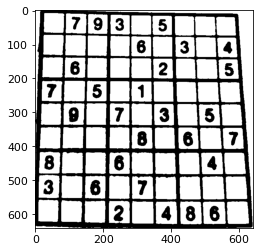

In [287]:
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
#gray9 = cv2.bilateralFilter(gray, 8, 75, 75)
gray3 = clahe.apply(gray)
#median = np.median(gray)
#retval, thresh = cv2.threshold(gray3, int(median * (1 - 0.33)), 255, cv2.THRESH_BINARY)
retval, thresh = cv2.threshold(gray3,0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print(median)
plt.imshow(thresh, cmap='gray')

81


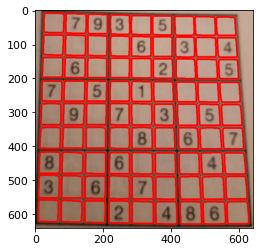

In [288]:
from scipy.spatial import ConvexHull
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# For each contour, find the convex hull and draw it
# on the original image.
img50 = img2.copy()
cells = []
for i in range(len(contours)):
    hull = cv2.convexHull(contours[i])
    if len(contours[i]) < 75 and len(hull) > 5:
        hull2 = ConvexHull(hull[:, 0, :])
        if hull2.volume > 2000:
            cells.append(hull2)
            cv2.drawContours(img50, [hull], -1, (255, 0, 0), 3)
print(len(cells))
plt.imshow(img50)

In [250]:
import numpy as np
import cv2

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

{89: 13, 90: 7}


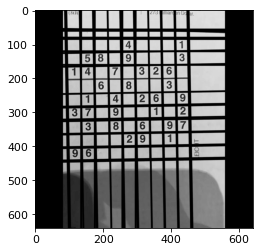

In [251]:
import math
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 25, 50)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 175, None, 0, 0)
an = {}
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    deg = (theta * 180) / np.pi
    if (deg > 75 and deg < 125):
        n = int(deg)
        if n not in an:
            an[n] = 0
        an[n] = an[n] + 1
    if (deg > 75 and deg < 125) or (deg < 10) or (deg > 170):
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(gray, pt1, pt2, (0, 0, 0), 3, cv2.LINE_AA)
print(an)
maxdeg = max(an, key=an.get)
rotated = rotate_image(gray, maxdeg - 90)
plt.imshow(gray, cmap='gray')

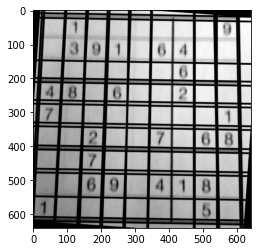

In [831]:
plt.imshow(rotated, cmap='gray')
gray = rotated

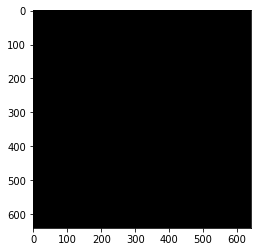

In [832]:
ret,thresh1 = cv2.threshold(gray,254,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(gray,254,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh1, cmap='gray')

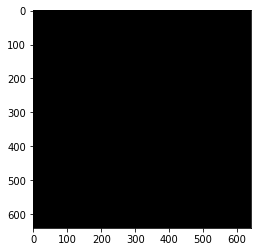

In [833]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (19, 19))
image_close = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel)
plt.imshow(image_close, cmap='gray')

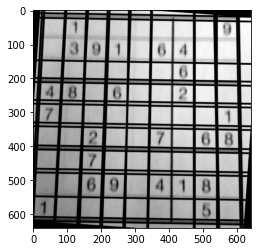

In [835]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated = cv2.dilate(image_close, kernel, iterations=2)
plt.imshow(dilated, cmap='gray')

In [759]:
def laplacian(image, alpha=10):
    normalized = image / 255.0
    laplacian = cv2.Laplacian(normalized, cv2.CV_64F)
    sharp = normalized - alpha * laplacian
    sharp[sharp > 1] = 1
    sharp[sharp < 0] = 0
    sharp = sharp * 255
    sharp = sharp.astype(np.uint8)
    return sharp

In [237]:
def unsharp_masking(image, k=10):
    normalized = image / 255.0
    blurred = cv2.GaussianBlur(normalized, (5, 5), 3, 3)
    mask = normalized - blurred
    sharp = normalized + k*mask
    sharp[sharp > 1] = 1
    sharp[sharp < 0] = 0
    sharp = sharp * 255
    sharp = sharp.astype(np.uint8)
    return sharp

81


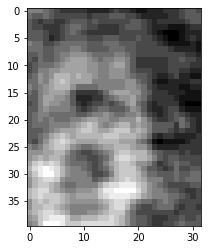

In [795]:
output = cv2.connectedComponentsWithStats(np.invert(dilated), 8, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]
stats[0, cv2.CC_STAT_WIDTH]
boxes = []
r = 0
row = []
imgp = cv2.imread(filename)
imgp = cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB)
for c in stats:
    l = c[cv2.CC_STAT_LEFT]
    t = c[cv2.CC_STAT_TOP]
    k = c[cv2.CC_STAT_WIDTH]
    k2 = c[cv2.CC_STAT_HEIGHT]
    if k <= 25 or k >= 300 or k2 <= 25 or k2 >= 300:
        pass
    else:
        box = (t, l, k2, k)
        boxes.append(box)
print(len(boxes))
s = sorted(boxes)
grid = []
above = None
for i in range(9):
    row = []
    grid.append(row)
    if i == 0:
        above = s[0]
        s.remove(above)
        row.append(above)
        for j in range(8):
            ma = None
            for b in s:
                if ma is None:
                    ma = b                
                elif b[0] <= above[0] + 15:
                    if b[1] <= ma[1]:
                        ma = b
            row.append(ma)
            s.remove(ma)
    else:
        rs = []
        mina = None
        for box in s:
            if box[0] > above[0] + 10:
                rs.append(box)
        a = 99999999
        for b in rs:
            if b[0] < a:
                a = b[0]
        for j in range(9):
            ma = None
            for b in s:
                if ma is None:
                    ma = b                
                elif b[0] <= a + 15:
                    if b[1] <= ma[1]:
                        ma = b
            row.append(ma)
            s.remove(ma)

t, l, k, k2 = grid[0][1]
cut = np.invert(gray)[t:t+k2, l:l+k].copy()
plt.imshow(cut, cmap='gray')

In [ ]:
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
digits = datasets.load_digits()
y = digits.target
x = digits.images.reshape((len(digits.images), -1))
x.shape
x_train = x[:1000]
y_train = y[:1000]
x_test = x[1000:]
y_test = y[1000:]

mlp = MLPClassifier(hidden_layer_sizes=(15,), activation='logistic', alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.1, verbose=True)
mlp.fit(x_train,y_train)

In [852]:
x_test[0]
xy = gray.reshape((1, -1))
xy.shape

(1, 409600)

In [857]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
custom_config = r'--oem 3 --psm 6 outputbase digits'
numbersa = []
numbersb = []
for row in range(9):
    for col in range(9):
        cell = grid[row][col]
        t, l, k, k2 = cell
        cut = gray[t:t+k2, l:l+k].copy()
        res = cv2.resize(cut, dsize=(8, 8), interpolation=cv2.INTER_CUBIC)
        res2 = res.reshape((1, -1))
        pred = mlp.predict(res2)
        numbersa.append(pred[0])
        numbersb.append(pytesseract.image_to_string(cut, config=custom_config))
print(numbersa)
print(numbersb)

[4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 4, 7, 4, 4, 4, 0, 4, 4, 4, 4, 4, 1, 4, 4, 4, 0, 4, 0, 0, 4, 4, 4, 4, 0, 0, 4, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 9, 4, 4, 0, 0, 4, 0, 4, 7, 7, 4, 4, 0, 4, 4, 0, 4, 7, 7, 7, 4, 0, 4, 7, 0, 4, 4, 4, 4, 7, 7, 2, 7, 2]
['', '', '', '', '', '', '5\n', '', '', '', '4\n', '', '7\n', '', '', '', '', '', '', '', '', '', '', '', '', '7\n', '', '', '', '', '6\n', '', '', '', '', '', '', '8\n', '', '', '', '', '', '', '7\n', '', '8\n', '', '', '4.\n', '4\n', '', '', '1\n', '', '', '', '', '', '', '', '.\n', '', '', '', '0\n', '', '-\n', '', '', '', '', '', '', '', '', '', '', '', '', '']


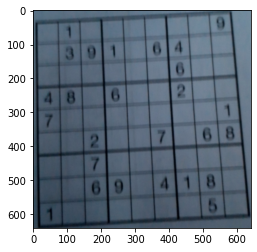

In [858]:
plt.imshow(img, cmap='gray')

In [498]:
detector = SudokuDetection(ImageAnalysis(), ImageTableExtraction())
success, encoded_image = cv2.imencode('.jpg', img4)
content = encoded_image.tobytes()
success, result = detector.detect(content)
print(success)
print(result)

False
[[['1', '', '9', '', '2 8', '', '', ''], ['4', '8', '5', '6', '', '9', '', ''], ['9', '', '4', '', '5', '', '', ''], ['6', '', '', '', '', '2', '', ''], ['', '', '8', '7', '9', '6', '', ''], ['', '', '', '', '7', '', '', '']], [['7', '9', '3', '', '5', '', ''], ['', '', '', '6', '', '3', '4'], ['6', '', '', '', '2', '', '5'], ['7', '5', '', '1', '', '', ''], ['9', '', '7', '', '3', '', '5'], ['', '', '', '8', '', '6', '7'], ['8', '', '6', '', '', '', '4'], ['3', '6', '', '7', '', '', ''], ['', '', '2', '', '4', '8', '6']]]


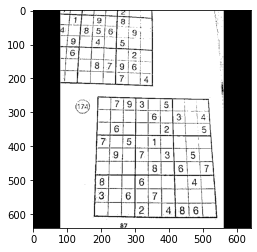

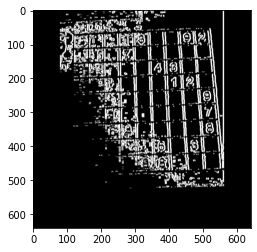

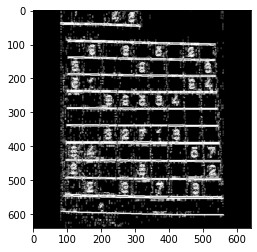

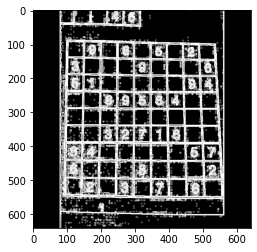